In [1]:
from tensorflow.keras.models import load_model
model = load_model('models/model_weights_resnet.h5',compile=False)

In [3]:
print(model.input_shape)

(None, 256, 256, 3)


In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [5]:
def preprocess_image(image_path, target_size):
    img = Image.open(image_path)
    img = img.resize(target_size)
    img_array = np.array(img)
    if img_array.shape[-1] == 4: 
        img_array = img_array[..., :3]
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0) 
    return img_array

def load_and_preprocess_mask(mask_path, target_size):
    mask = Image.open(mask_path)
    mask = mask.resize(target_size)
    mask_array = np.array(mask)
    if mask_array.ndim == 3 and mask_array.shape[-1] == 4:
        mask_array = mask_array[..., 0]  
    mask_array = mask_array > 0 
    return mask_array.astype(np.uint8)

def calculate_iou(predicted_mask, ground_truth_mask):
    intersection = np.logical_and(predicted_mask, ground_truth_mask)
    union = np.logical_or(predicted_mask, ground_truth_mask)
    iou = np.sum(intersection) / np.sum(union)
    return iou

def post_process_mask(mask):
    kernel = np.ones((5, 5), np.uint8) 
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)  
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)   
    mask = cv2.GaussianBlur(mask, (5, 5), 0)
    return mask

def watershed_algorithm(image, binary_mask):
    # Compute the sure foreground area by distance transform and thresholding
    dist_transform = cv2.distanceTransform(binary_mask, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    
    # Compute the sure background area by dilating the binary mask
    sure_bg = cv2.dilate(binary_mask, np.ones((3, 3), np.uint8), iterations=3)
    sure_bg = cv2.subtract(sure_bg, sure_fg)

    # Label the markers for the watershed algorithm
    ret, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[sure_bg == 255] = 0

    # Apply the watershed algorithm
    image_with_markers = image.copy()
    markers = cv2.watershed(image_with_markers, markers)
    image_with_markers[markers == -1] = [255, 0, 0]
    watershed_mask = (markers > 1).astype(np.uint8)
    
    return watershed_mask

In [6]:
# Paths to the original image and binary mask
img_path = "DL52_9309_8_3.tif"
target_size = (256, 256)
preprocessed_image = preprocess_image(img_path, target_size)



In [7]:
# Make predictions
predictions = model.predict(preprocessed_image)
predictions_binary = (predictions > 0.43).astype(np.uint8)

original_image_path = "DL52_9309_8_3.tif"
original_image = cv2.imread(original_image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB) 
original_image_resized = cv2.resize(original_image, (256, 256))

ground_truth_mask_path = "dataset\labels\DL52_9309_8_3.tif"
ground_truth_mask = load_and_preprocess_mask(ground_truth_mask_path, target_size)

binary_mask = predictions_binary[0]
post_processed_mask = post_process_mask(binary_mask)



1/1 [==============================] - 7s 7s/step


In [8]:
# Apply the watershed algorithm to the original image and the post-processed mask
watershed_mask = watershed_algorithm(original_image_resized, post_processed_mask)

# Combine the post-processed mask and the watershed mask
combined_mask = np.logical_or(post_processed_mask, watershed_mask).astype(np.uint8)

# Create the overlay image for visualization
overlay_image = np.zeros_like(original_image_resized)
mask_color = np.array([255, 0, 0], dtype=np.uint8)  
overlay_image[combined_mask > 0] = mask_color

alpha = 0.5 
annotated_image = cv2.addWeighted(original_image_resized, alpha, overlay_image, 1 - alpha, 0)



(-0.5, 255.5, 255.5, -0.5)

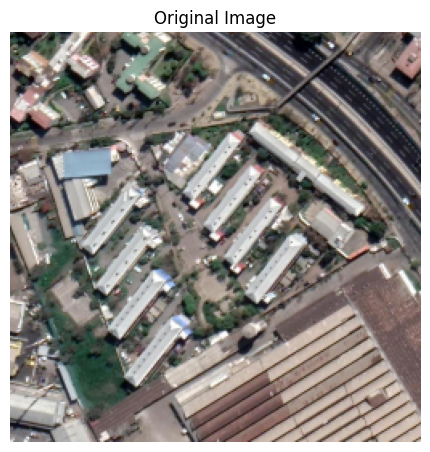

In [9]:
# Display the original image, annotated image, and contour image in a single row
plt.figure(figsize=(18, 6))

# Display Original Image
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(original_image_resized)
plt.axis('off')






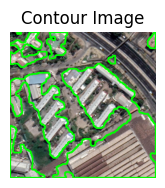

In [10]:
# Display Contour Image
contours, _ = cv2.findContours(combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour_image = original_image_resized.copy()
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2) 

plt.subplot(1, 3, 3)
plt.title('Contour Image')
plt.imshow(contour_image)
plt.axis('off')

plt.show()



In [11]:
# Calculate IoU scores
iou_score_processed = calculate_iou(combined_mask, ground_truth_mask)
iou_score_unprocessed = calculate_iou(binary_mask, ground_truth_mask)



In [12]:
# Print IoU Scores
print(f"IoU Score (Processed): {iou_score_processed}")
print(f"IoU Score (Unprocessed): {iou_score_unprocessed}")



IoU Score (Processed): 0.5020785636823714
IoU Score (Unprocessed): 0.20332703386893927


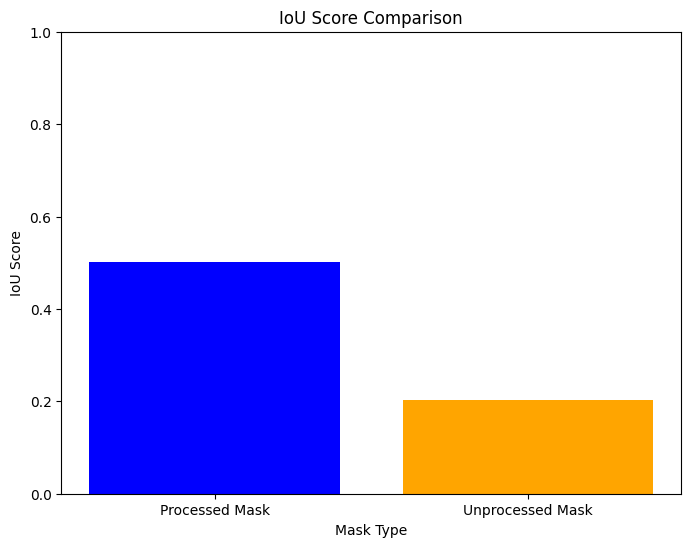

In [13]:
# Visualize IoU Comparison
plt.figure(figsize=(8, 6))
plt.bar(['Processed Mask', 'Unprocessed Mask'], [iou_score_processed, iou_score_unprocessed], color=['blue', 'orange'])
plt.xlabel('Mask Type')
plt.ylabel('IoU Score')
plt.title('IoU Score Comparison')
plt.ylim(0, 1)  # Set y-axis limits for better comparison
plt.show()